## Importing the required libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, recall_score

## Loading Data 

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Creating CNN

In [25]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
    model.add(MaxPool2D(2, 2))
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

## Preprocess the Data

In [26]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

## Cross Validation

In [27]:
def cross_validation(model, x_train, y_train, n_splits = 6):
    skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)
    precision_scores = []
    accuracy_scores = []
    f1_scores = []
    recall_scores = []
    confusion_matrices = []

    for train_index, val_index in skf.split(x_train, y_train.argmax(axis=1)):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(x_train_fold, y_train_fold, epochs = 10, verbose = 1)

        y_val_pred = model.predict(x_val_fold)
        y_val_true = np.argmax(y_val_fold, axis = 1)
        y_val_pred = np.argmax(y_val_pred, axis = 1)

        precision = precision_score(y_val_true, y_val_pred, average = 'weighted')
        accuracy = accuracy_score(y_val_true, y_val_pred)
        f1 = f1_score(y_val_true, y_val_pred, average = 'weighted')
        recall = recall_score(y_val_true, y_val_pred, average = 'weighted')

        confusion = confusion_matrix(y_val_true, y_val_pred)

        precision_scores.append(precision)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)
        confusion_matrices.append(confusion)

    return {
        'precision_scores': precision_scores,
        'accuracy_scores': accuracy_scores,
        'f1_scores': f1_scores,
        'recall_scores': recall_scores,
        'confusion_matrices': confusion_matrices
    }

## Performing Cross Validation

In [28]:
model = create_cnn_model()
cv_results = cross_validation(model, x_train, y_train)

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.1772 - accuracy: 0.9476
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0598 - accuracy: 0.9816
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0398 - accuracy: 0.9877
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0259 - accuracy: 0.9920
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0191 - accuracy: 0.9940
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0126 - accuracy: 0.9960
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0099 - accuracy: 0.9969
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0076 - accuracy: 0.9975
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0064 - accuracy: 0.9976
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - l

## Plotting Confusion Matrices as Heatmaps

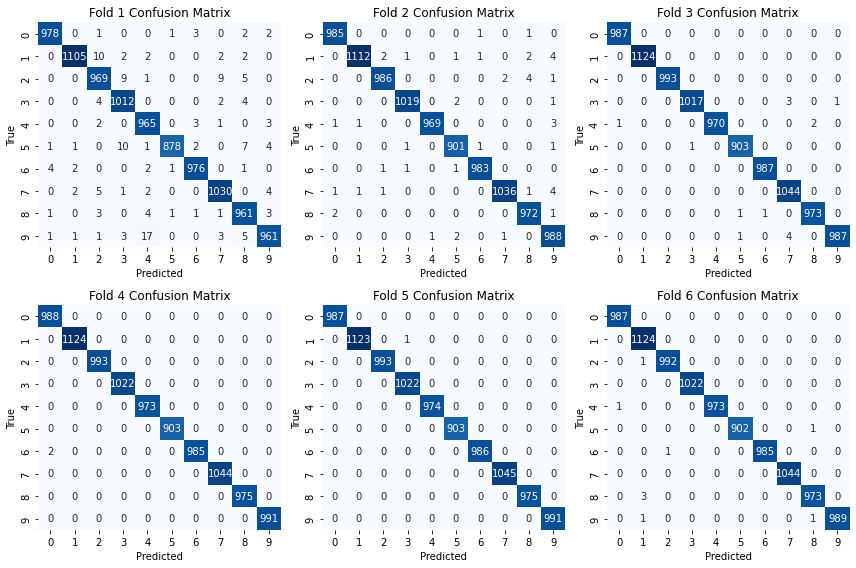

In [29]:
plt.figure(figsize = (12, 8))
for i, cm in enumerate(cv_results['confusion_matrices']):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False)
    plt.title(f'Fold {i + 1} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()

## Plotting Precision, Accuracy, F1 Score and Recall for Each Fold

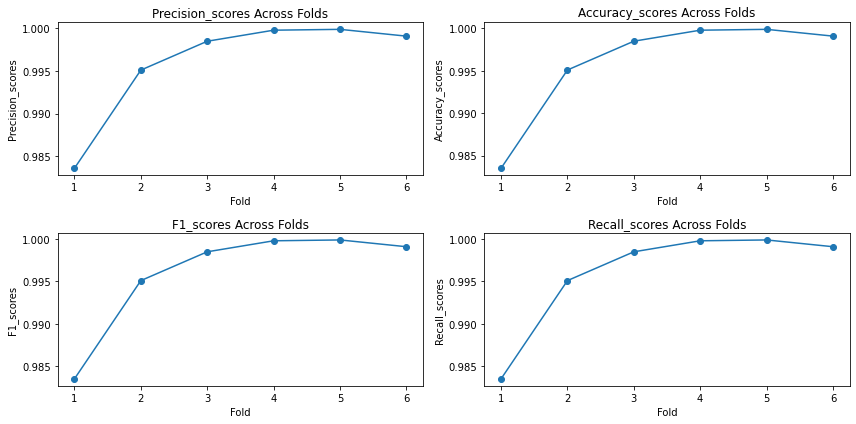

In [30]:
plt.figure(figsize = (12, 6))
metrics = ['precision_scores', 'accuracy_scores', 'f1_scores', 'recall_scores']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(range(1, 7), cv_results[metric], marker = 'o')
    plt.title(f'{metric.capitalize()} Across Folds')
    plt.xlabel('Fold')
    plt.ylabel(metric.capitalize())
plt.tight_layout()

# Plotting Mean Square Error Curve as a function of epoch

In [31]:
def create_error_curve(param_values, x_train, y_train, x_val, y_val):
    train_errors = []
    val_errors = []

    for param in param_values:
        model = create_cnn_model()
        history = model.fit(x_train, y_train, epochs = param, validation_data = (x_val, y_val), verbose = 1)
        train_mse = np.mean(np.square(model.predict(x_train) - y_train))
        val_mse = np.mean(np.square(model.predict(x_val) - y_val))
        train_errors.append(train_mse)
        val_errors.append(val_mse)

    return train_errors, val_errors

## Defining Range of Epochs to explore

In [32]:
epochs_range = [1, 5, 10, 15, 20]

## Splitting into Training and Validation Sets

In [33]:
val_split = 0.2
split_index = int((1 - val_split) * len(x_train))
x_val, y_val = x_train[split_index:], y_train[split_index:]
x_train, y_train = x_train[:split_index], y_train[:split_index]

## Creating Error Curve

In [34]:
train_errors, val_errors = create_error_curve(epochs_range, x_train, y_train, x_val, y_val)

1500/1500 [==============================] - 11s 7ms/step - loss: 0.1693 - accuracy: 0.9503 - val_loss: 0.0749 - val_accuracy: 0.9776
Epoch 1/5
1500/1500 [==============================] - 13s 8ms/step - loss: 0.1782 - accuracy: 0.9476 - val_loss: 0.0747 - val_accuracy: 0.9798
Epoch 2/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0593 - accuracy: 0.9826 - val_loss: 0.0666 - val_accuracy: 0.9795
Epoch 3/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0396 - accuracy: 0.9881 - val_loss: 0.0620 - val_accuracy: 0.9812
Epoch 4/5
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0277 - accuracy: 0.9915 - val_loss: 0.0521 - val_accuracy: 0.9852
Epoch 5/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0186 - accuracy: 0.9942 - val_loss: 0.0630 - val_accuracy: 0.9818
Epoch 1/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.1819 - accuracy: 0.9474 - val_loss: 0.0838 - val_accuracy: 0.9757
E

## Plotting the Error Curve

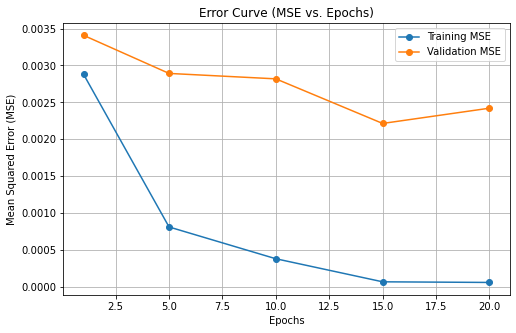

In [35]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_range, train_errors, label = 'Training MSE', marker = 'o')
plt.plot(epochs_range, val_errors, label = 'Validation MSE', marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Error Curve (MSE vs. Epochs)')
plt.legend()
plt.grid(True)
plt.show()